In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import sys
import os

# Récupérer le chemin du répertoire parent de 'Preliminaire_travail_donnees'
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)

# Ajouter ce répertoire parent au sys.path si ce n'est pas déjà fait
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Maintenant, l'importation devrait fonctionner
from tennis_app.joueur.creer_joueur import creer_joueur


In [50]:
def preaprer_liste_id(genre, type = None, rang_max =None):
    if type is None:

        if genre == "H":
            liste_fichier = [
                "../Donnees/atp_matches_1968_2024.csv",
                "../Donnees/atp_matches_futures_1992_2024.csv",
                "../Donnees/atp_matches_qual_1978_2024.csv"
                ]
        elif genre == "F":
            liste_fichier = [
                "../Donnees/wta_matches_1968_2024.csv",
                "../Donnees/wta_matches_qual_1968_2024.csv"
                ]
        else:
            liste_fichier = [
                "../Donnees/atp_matches_1968_2024.csv",
                "../Donnees/atp_matches_futures_1992_2024.csv",
                "../Donnees/atp_matches_qual_1978_2024.csv",
                "../Donnees/wta_matches_1968_2024.csv",
                "../Donnees/wta_matches_qual_1968_2024.csv"
                ]

        data = pd.DataFrame()
        for fichier in liste_fichier:
            data_temp = pd.read_csv(fichier, low_memory=False)
            data = pd.concat([data, data_temp], axis=0)

        data = data[data["annee"] == 2024]

        # Récupération d'un liste d'Id_joueur
        liste_id_win = list(data["winner_id"].unique())
        liste_id_los = list(data["loser_id"].unique())
        liste_id = list(set(liste_id_win + liste_id_los))

    else:
        if genre == "H":
            data = pd.read_csv("../Donnees/atp_rankings.csv")
        elif genre == "F":
            data = pd.read_csv("../Donnees/wta_rankings.csv")
        else:
            dataH = pd.read_csv("../Donnees/atp_rankings.csv")
            dataF = pd.read_csv("../Donnees/wta_rankings.csv")
            data = pd.concat([dataH, dataF], axis=0)

        date = (data["ranking_date"].unique()).max()
        data = data[data["ranking_date"] == date].copy()

        if rang_max is not None:
            data = data[data["rank"] < rang_max]


        # Récupération d'un liste d'Id_joueur
        liste_id = list(data["player"].unique())

    return liste_id


def preparer_joueurs(liste_id, genre):
    """
    Prépare les données pour la classification, en s'assurant d'avoir exactement
    nb_element_cible joueurs valides.
    """
    if genre == 'H':
        data = [pd.read_csv("../Donnees/atp_players.csv")]
    elif genre == 'F':
        data = [pd.read_csv("../Donnees/wta_players.csv")]
    else:
        dataH = pd.read_csv("../Donnees/atp_players.csv")
        dataF = pd.read_csv("../Donnees/wta_players.csv")
        data = [dataH, dataF]

    joueurs = []  # Liste d'objets Joueur

    attributs_numeriques_a_verifier = [
        "nb_tournois_gagne",
        "prop_vic_set_1_perdu",
        "prop_balle_break_sauvee",
        "nb_sem_classe"
    ]

    for id in liste_id:
        joueur = creer_joueur(id=id, info=(data, genre))

        if joueur is not None:
            est_valide = True
            for attribut in attributs_numeriques_a_verifier:
                try:
                    valeur_attribut = getattr(joueur, attribut)
                    if math.isnan(valeur_attribut):
                        est_valide = False
                        break  # Sortir de la boucle dès qu'un NaN est trouvé
                except AttributeError:
                    est_valide = False
                    break

            if est_valide:
                joueurs.append(joueur)

    return joueurs


def preparer_features(joueur, genre):
    features = [
        # Ratio victoires/tournois
        joueur.nb_tournois_gagne / joueur.nb_tournois_joue*100 if joueur.nb_tournois_joue != 0 else 0,
        # Capacité à remonter après un set perdu (en pourcentage directement)
        joueur.prop_vic_set_1_perdu,
        # Résistance sous pression (en pourcentage directement)
        joueur.prop_balle_break_sauvee,
        # Proportion de temps dans le top 10
        joueur.nb_sem_1_10 / joueur.nb_sem_classe * 100 if joueur.nb_sem_classe != 0 else 0,
        # Proportion de temps dans le top 11-50
        joueur.nb_sem_11_50 / joueur.nb_sem_classe * 100 if joueur.nb_sem_classe != 0 else 0,
        # Proportion de temps dans le top 51-100
        joueur.nb_sem_51_100 / joueur.nb_sem_classe * 100 if joueur.nb_sem_classe != 0 else 0]


    # Encodage one-hot pour la main dominante
    if joueur.main == 'R':
        features.extend([100, 0])  # [est_droitier, est_gaucher]
    elif joueur.main == 'L':
        features.extend([0, 100])
    else:
        features.extend([0, 0])

    if genre == 'M':
        # Encodage one-hot pour le sexe (valable uniquement pour cas 3 classification mixte)
        if joueur.sexe == 'F':
            features.extend([0, 100])
        else:
            features.extend([100, 0])

    return features


def preparer_donner(joueurs, genre):

    X = []
    noms_joueurs = []

    for joueur in joueurs:
        features = preparer_features(joueur, genre)
        X.append(features)
        noms_joueurs.append(f"{joueur.prenom} {joueur.nom}")

    # Convertir en array numpy
    X = np.array(X)

    # Normaliser les données -> inutil ici toutes les features sont entre 0 et 1
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)

    return X

def visualiser_repartition_features(X, feature_names):
    """
    Affiche des histogrammes pour visualiser la répartition de chaque feature.

    Args:
        X (numpy.ndarray): Le tableau des features.
        feature_names (list): La liste des noms de chaque feature.
    """
    num_features = X.shape[1]
    plt.figure(figsize=(15, 10))
    num_rows = 2
    num_cols = math.ceil(num_features / num_rows)
    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        n, bins, patches = plt.hist(X[:, i], bins=20, edgecolor='black', density=False) # density=False pour obtenir les counts

        plt.title(feature_names[i])
        plt.xlabel('Valeur')


        total_count = len(X[:, i])
        plt.ylabel('Fréquence (%)')
        # Formatter l'axe des y pour afficher le pourcentage
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y / total_count if total_count > 0 else 0)))

    plt.tight_layout()
    plt.show()

def colonnes(genre):
    colonnes = [
            'Ratio victoires',
            'Remontées après set perdu',
            'Balles de break sauvées',
            'Temps top 10',
            'Temps top 11-50',
            'Temps top 51-100',
            'Main Droite',
            'Main Gauche'
        ]
    if genre == "M":
        colonnes.extend(["Sexe Homme", "Sexe Femme"])

    return colonnes


In [51]:
def afficher_repartition(genre, type = None, rang_max = None):

    liste_id = preaprer_liste_id(genre, type , rang_max)
    joueurs = preparer_joueurs(liste_id, genre)
    if joueurs:
        X = preparer_donner(joueurs, genre)
        feature_names = colonnes(genre)
        if X.shape[1] == len(feature_names):
            visualiser_repartition_features(X, feature_names)
        else:
            print("Erreur: Le nombre de features ne correspond pas au nombre de noms de colonnes pour les hommes.")
    else:
        print("Aucun joueur homme valide trouvé.")

# Pour les Hommes

3319


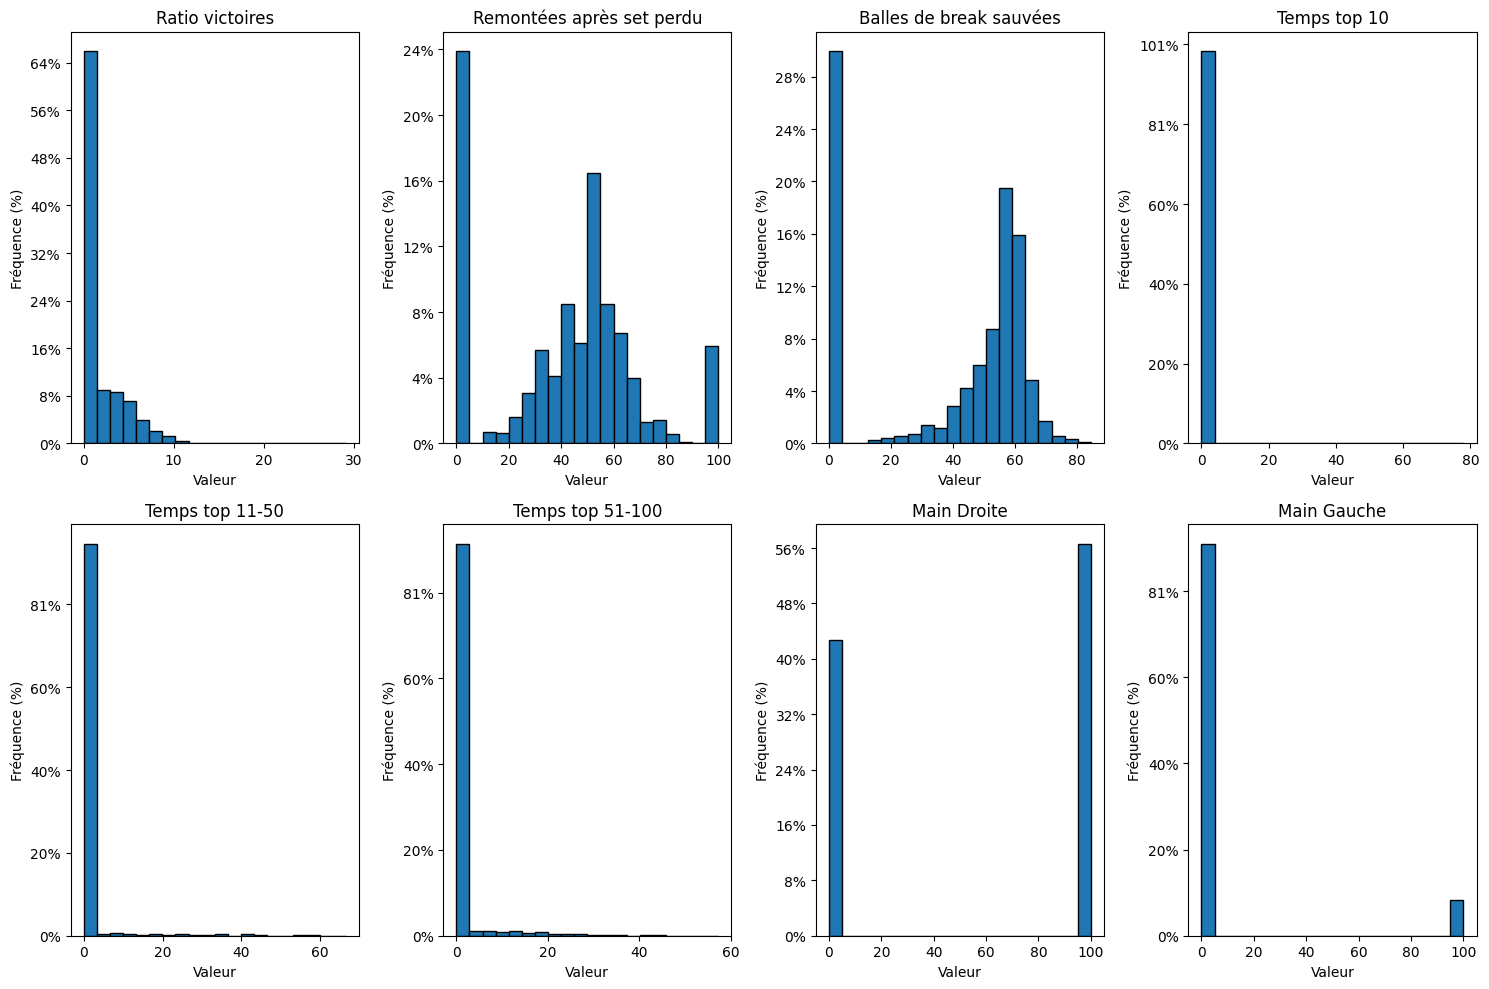

In [45]:
afficher_repartition('H')

2024-12-30
2161


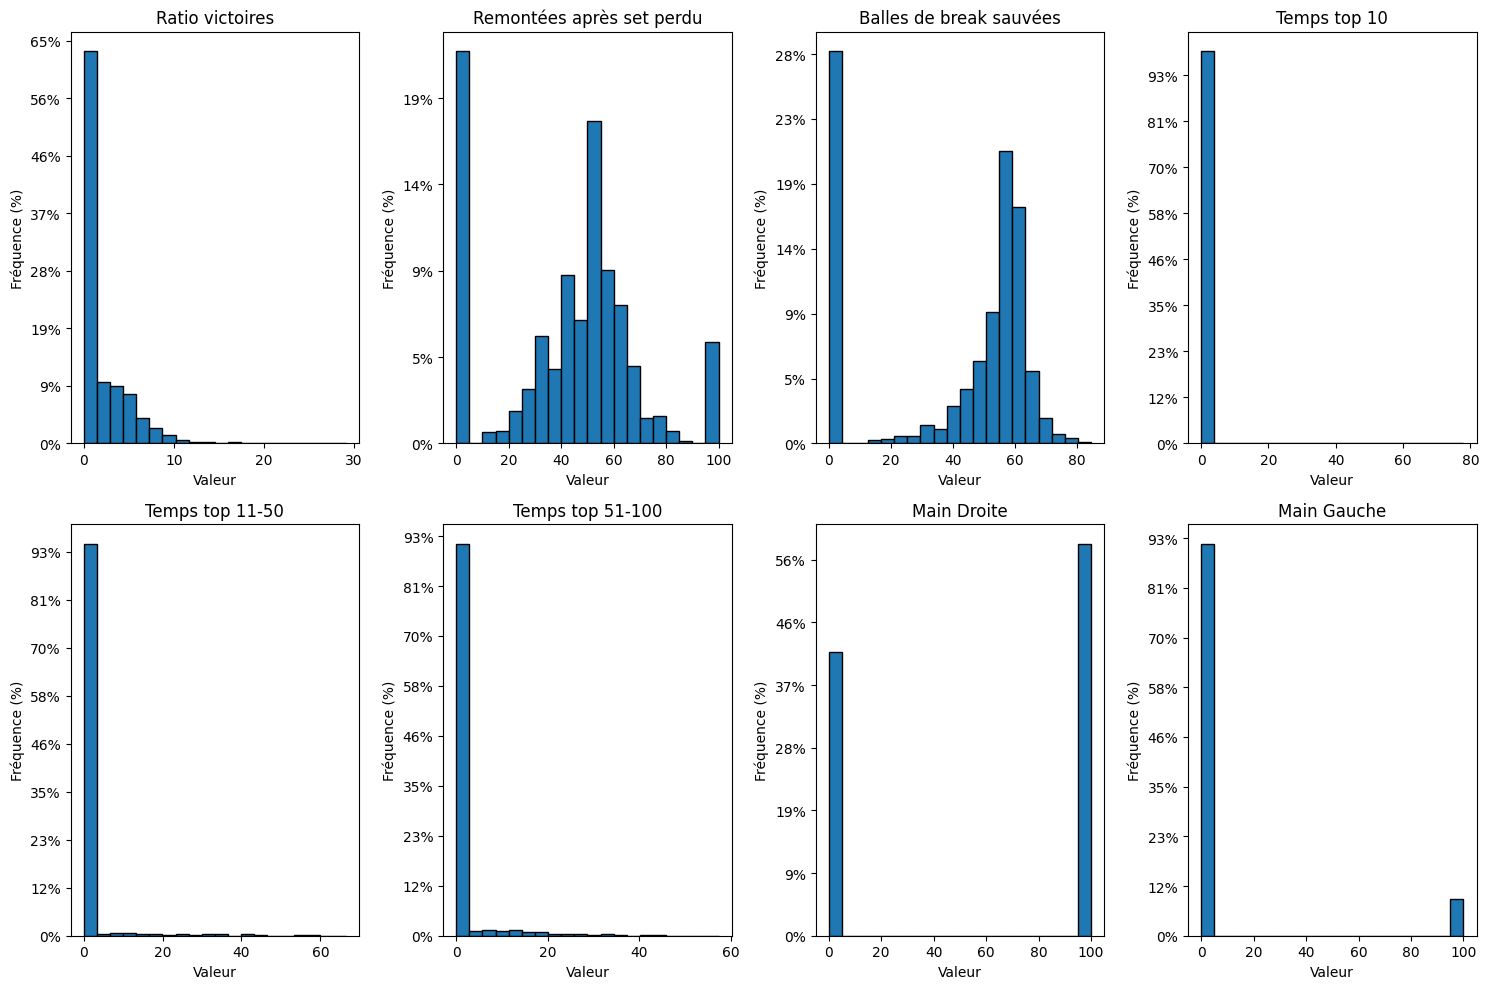

In [46]:
afficher_repartition('H',"classe")

2024-12-30
199


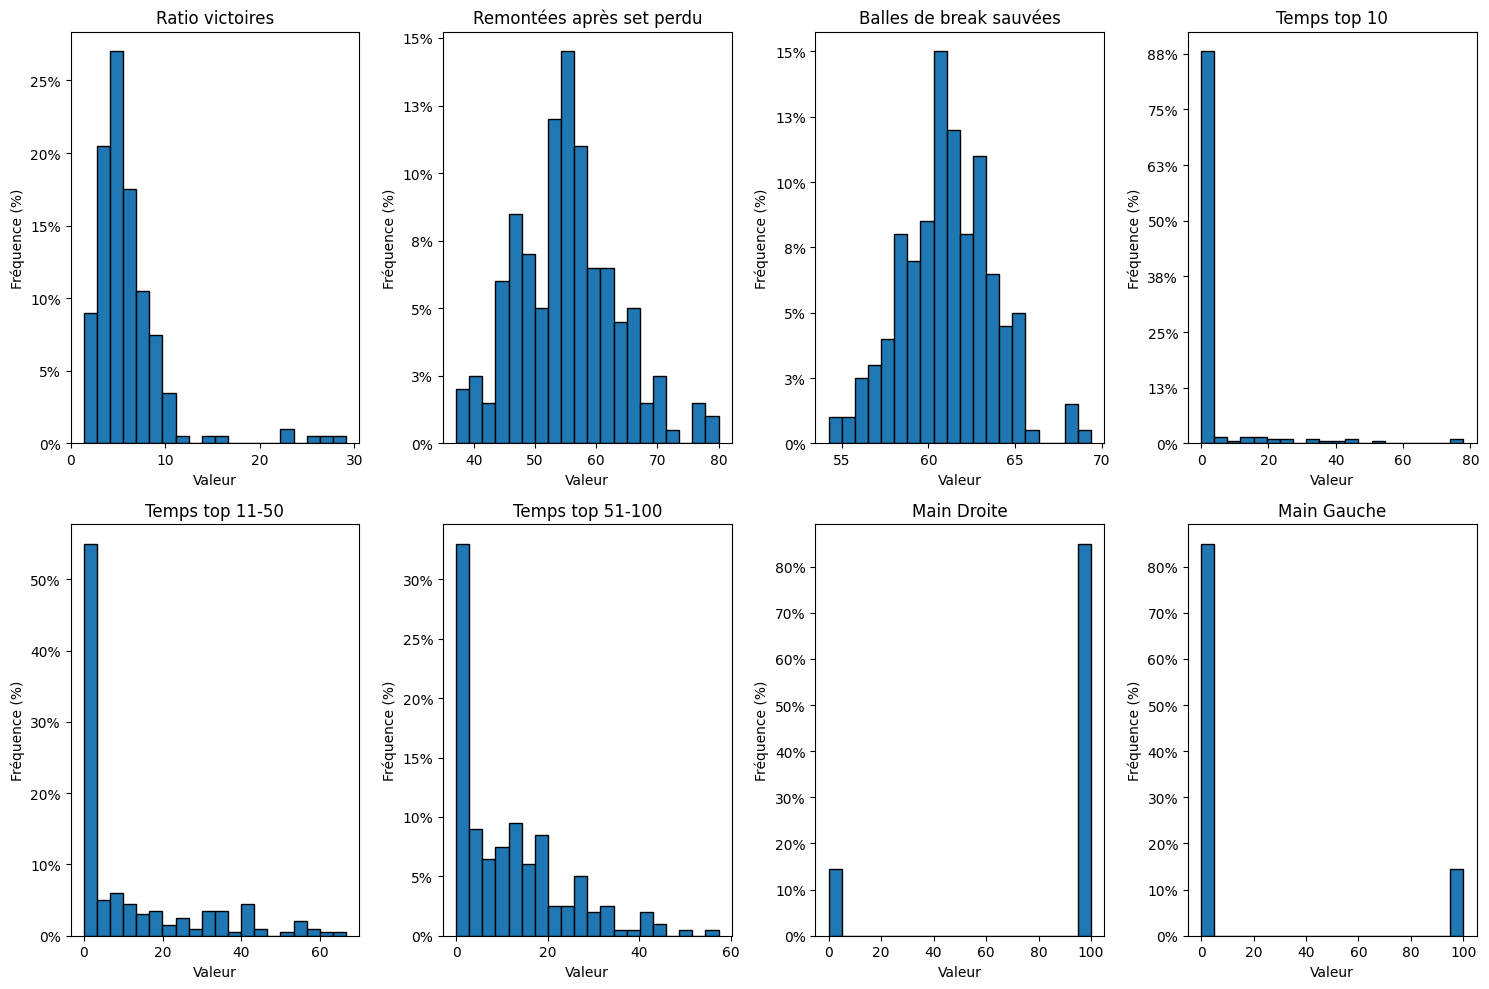

In [47]:
afficher_repartition('H',"classe",200)

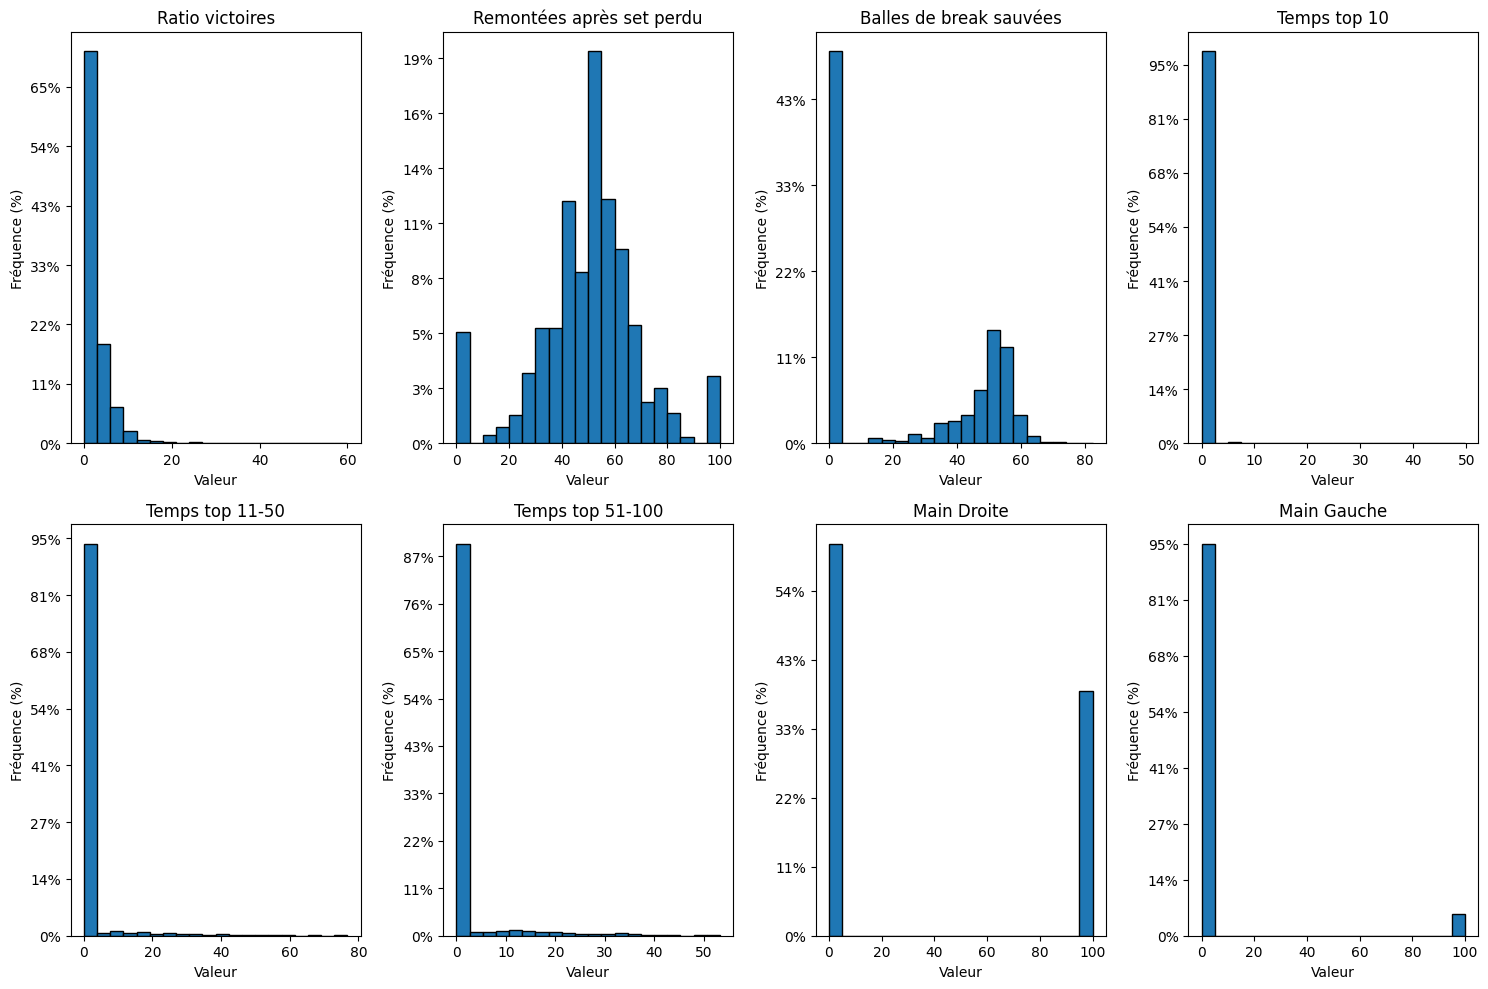

In [52]:
afficher_repartition('F')

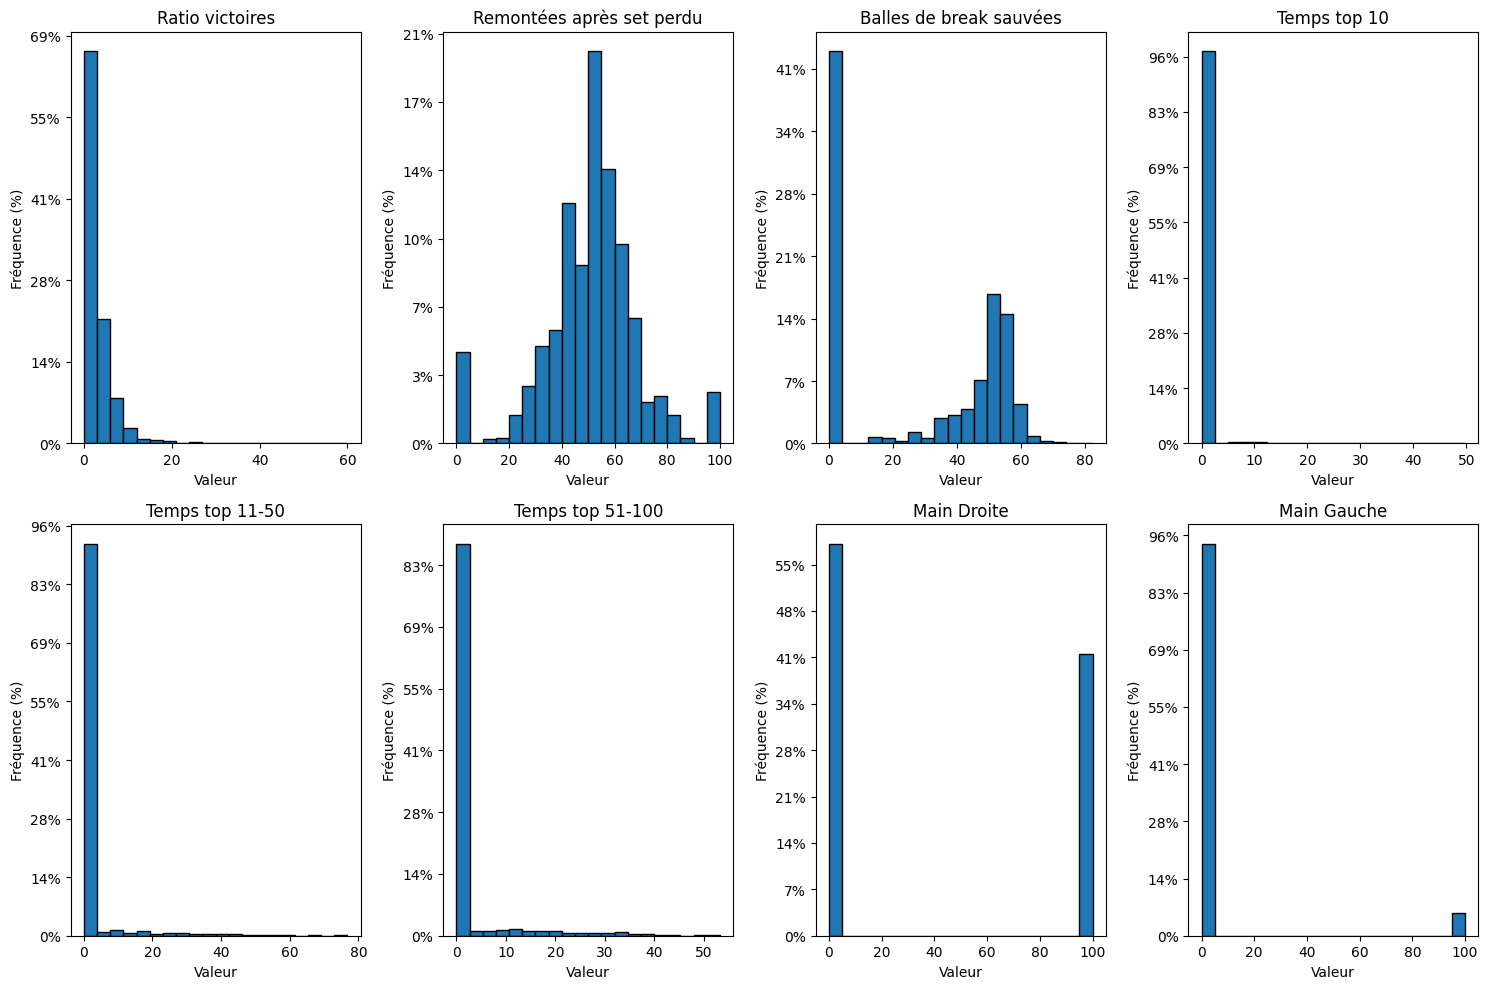

In [53]:
afficher_repartition('F',"classe")

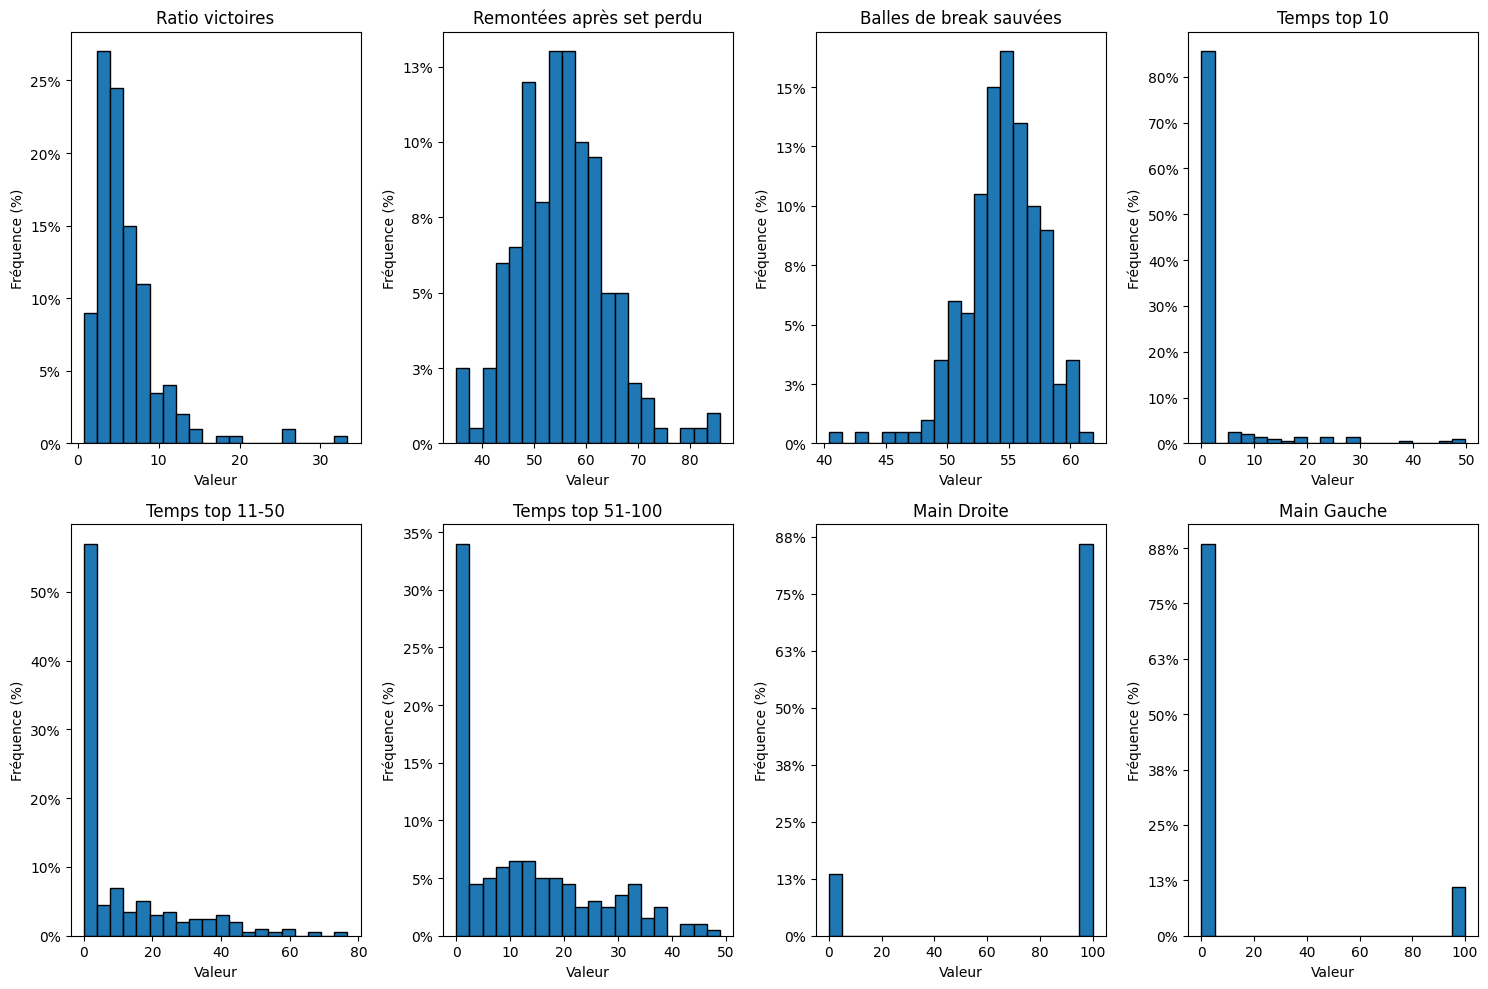

In [54]:
afficher_repartition('F',"classe",200)

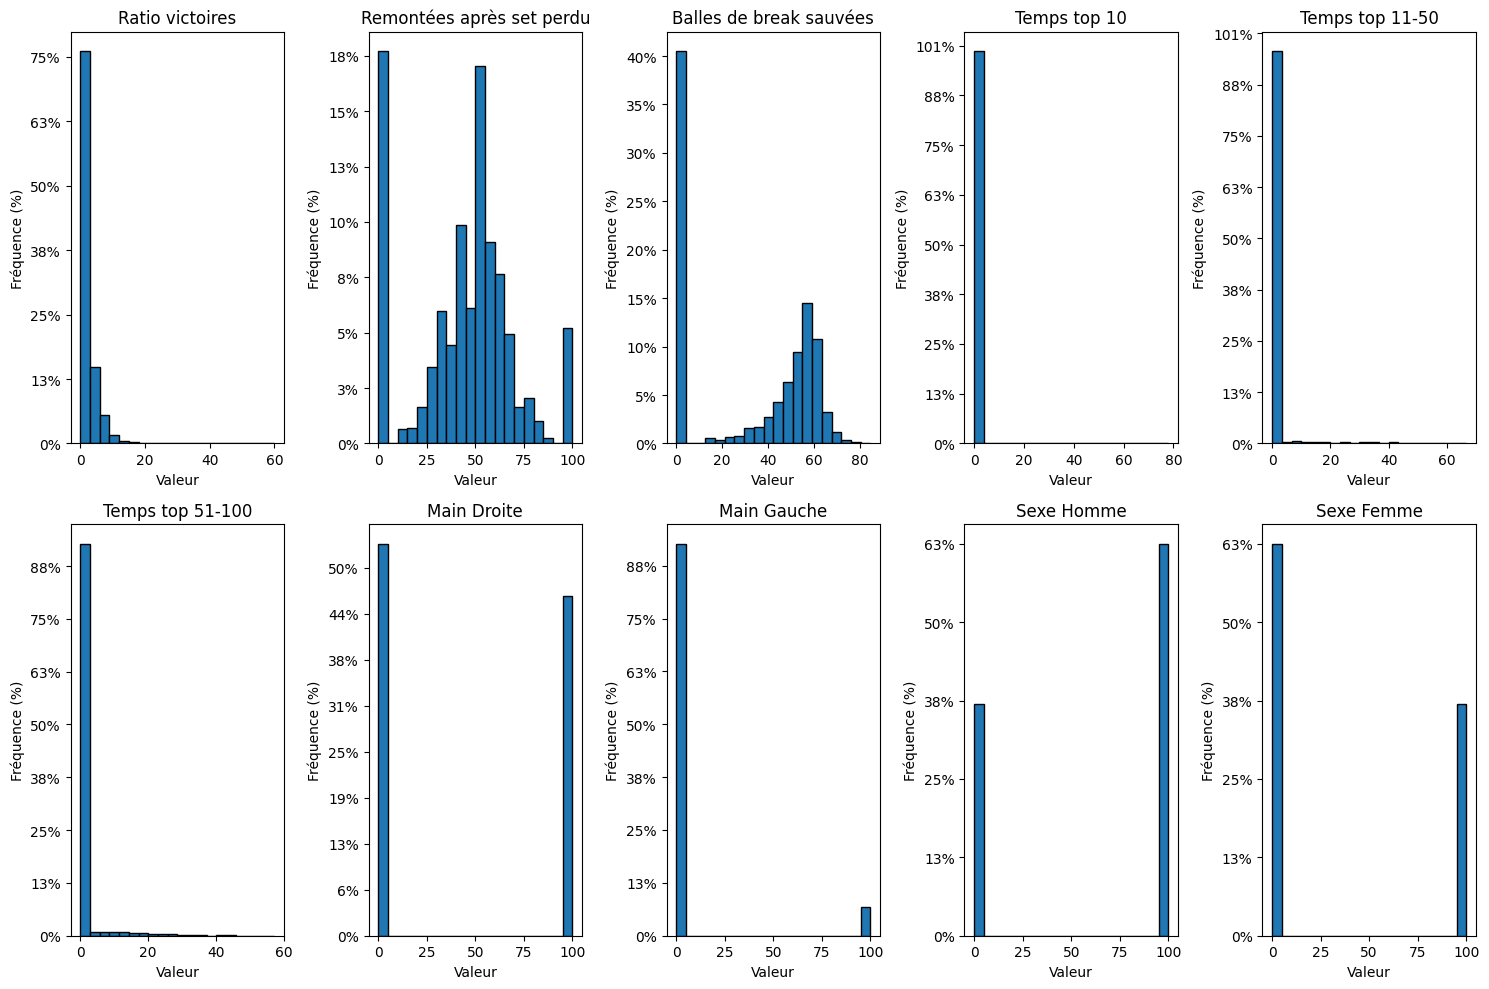

In [55]:
afficher_repartition('M')

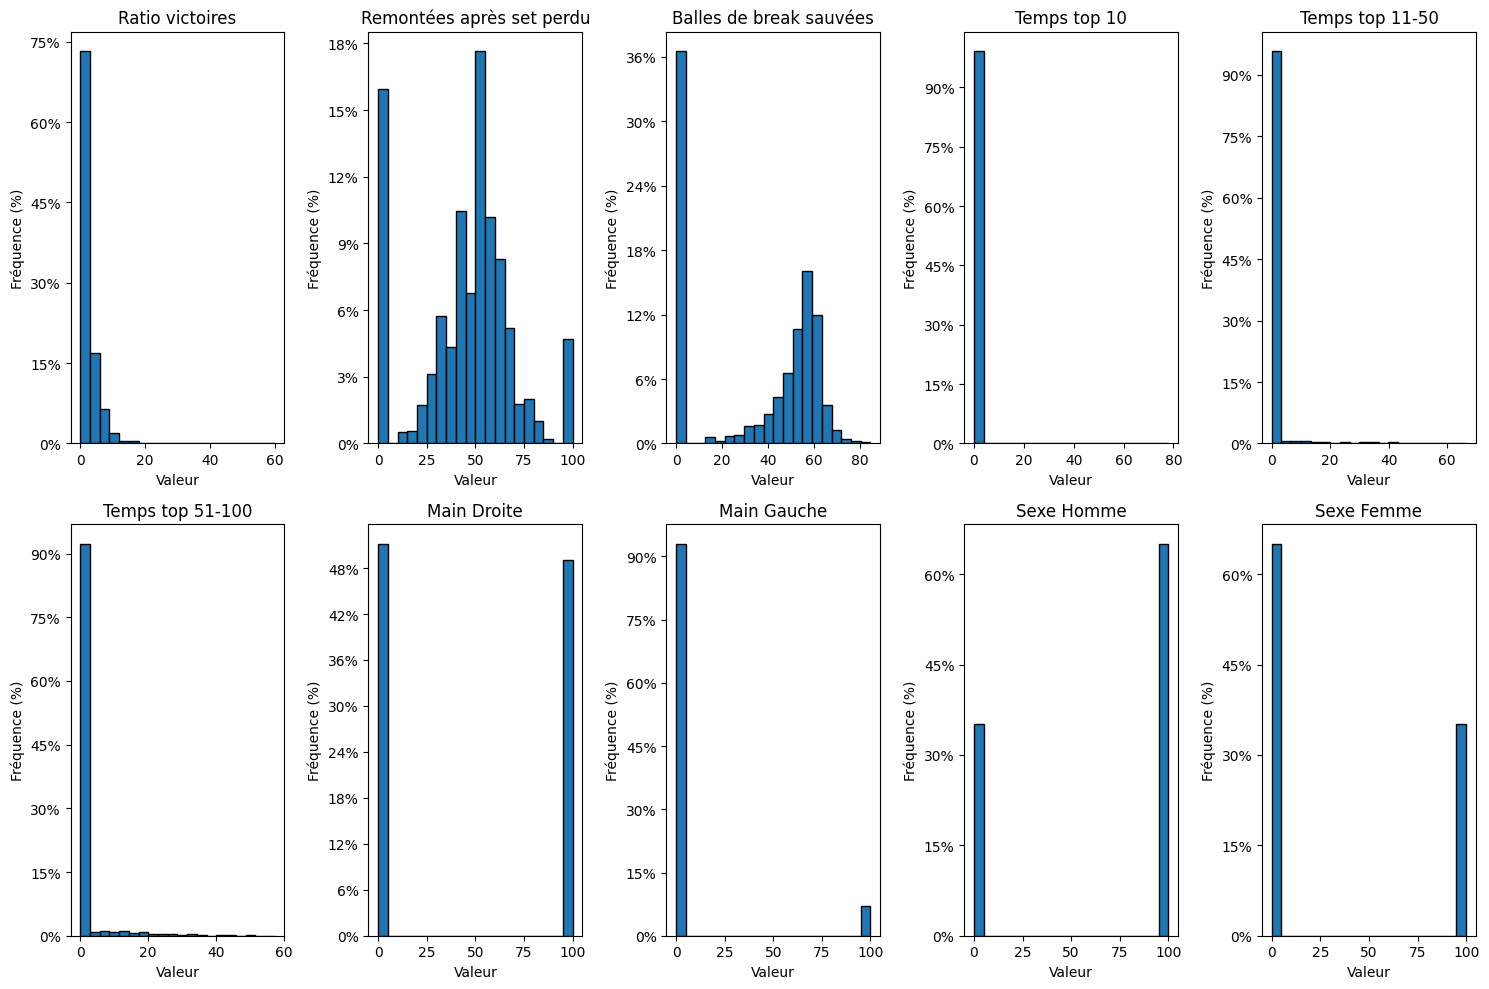

In [56]:
afficher_repartition('M',"classe")

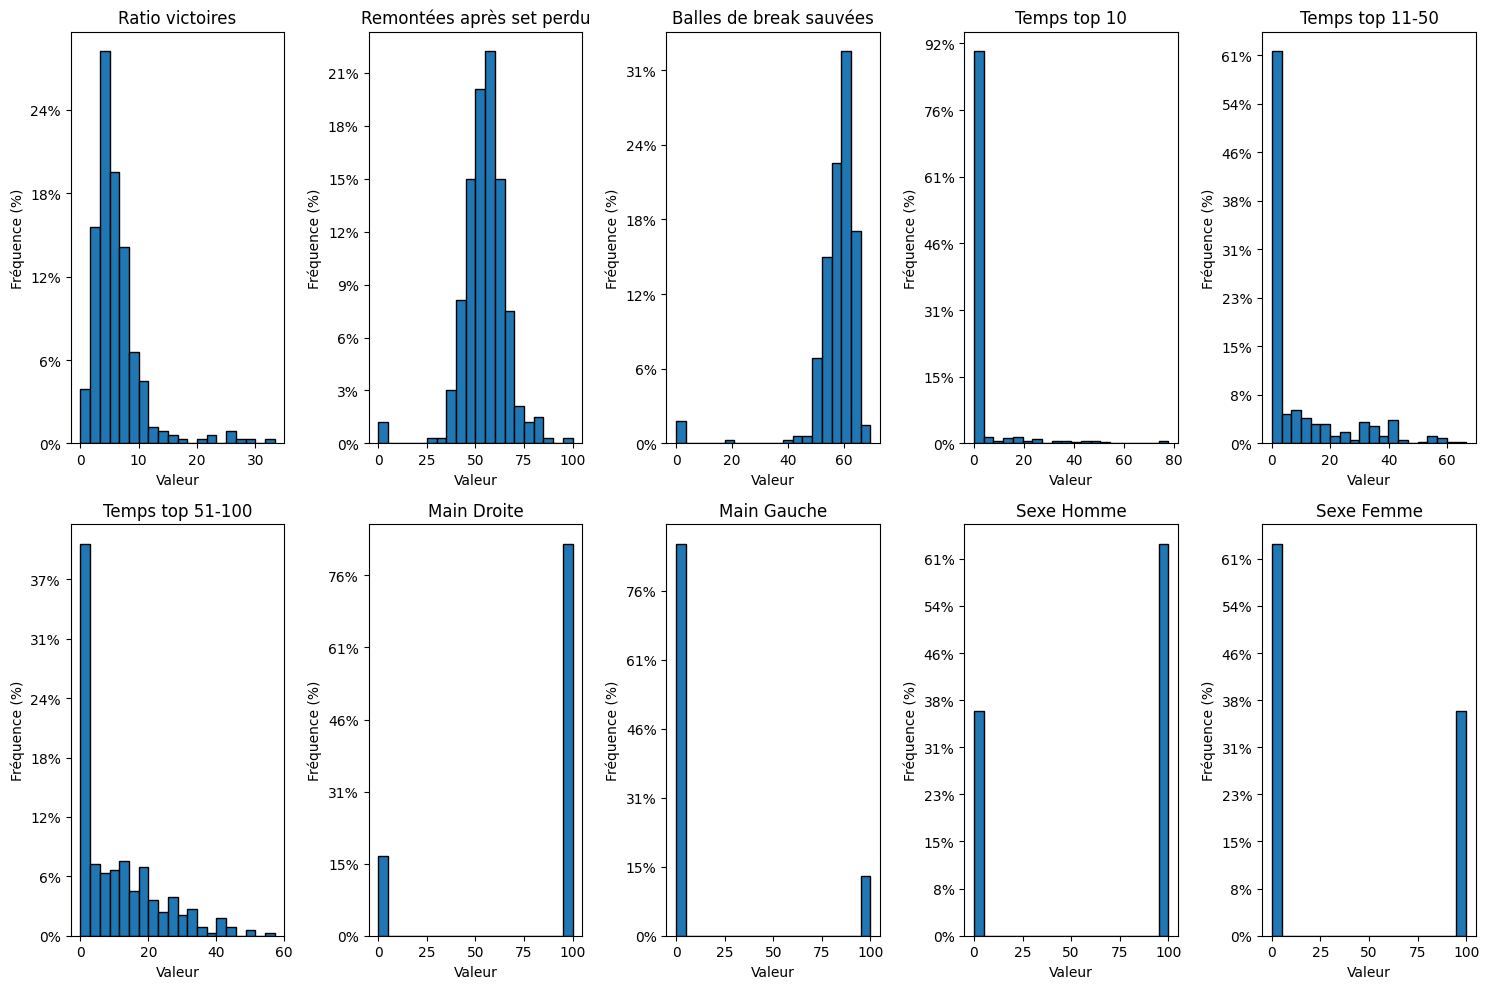

In [57]:
afficher_repartition('M',"classe",200)